<a href="https://colab.research.google.com/github/MikeSalnikov/Data-analysis-algorithms/blob/main/HW5_web5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 5

Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.
Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).
Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap

import numpy as np

In [ ]:
# сгенерирую данные, представляющие собой 1000 объектов с двумя признаками: 

from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000,
                           n_features=2, n_informative=2, 
                           n_classes=2, n_redundant=0, 
                           n_clusters_per_class=2, flip_y=0.1, random_state=1)

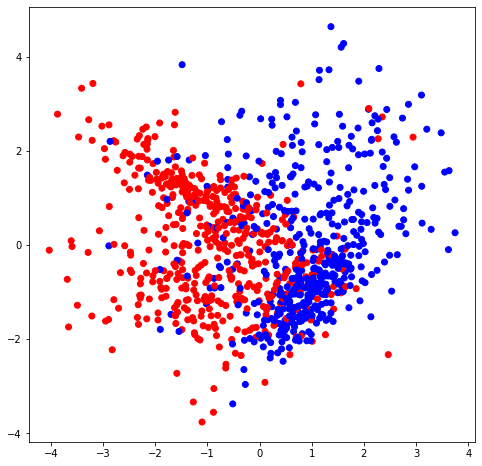

In [ ]:
# визуализирую сгенерированные данные: 

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], 
              c=y, cmap=colors);

Реализую генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле:

In [ ]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [ ]:
def get_subsample(len_sample):
    # буду сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

Далее повторю реализацию построения дерева решений из предыдущего урока с некоторыми изменениями:

In [ ]:
# реализую класс узла: 

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# реализую класс терминального узла (листа): 

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформирую словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найду класс, количество объектов которого будет максимальным в этом листе и верну его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [ ]:
# расчет критерия Джини: 

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [ ]:
# расчет прироста: 

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [ ]:
# разбиение датасета в узле: 

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# нахождение наилучшего разбиения: 

def find_best_split(data, labels):
    
    #  обозначу минимальное количество объектов в узле
#     min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираю случайные признаки
    
    for index in feature_subsample_indices:
        # буду проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаю разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираю порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [ ]:
# построение дерева с помощью рекурсивной функции: 

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  базовый случай - прекращаю рекурсию, когда нет прироста в качество
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # рекурсивно строю два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # возвращаю класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавлю функцию формирования случайного леса:

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [ ]:
# функция классификации отдельного объекта: 

def classify_object(obj, node):

    #  останавливаю рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
# функция формирования предсказания по выборке на одном дереве: 

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# предсказание голосованием деревьев: 

def tree_vote(forest, data):

    # добавлю предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформирую список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберу в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [ ]:
# разобью выборку на обучающую и тестовую: 

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [ ]:
# введу функцию подсчета точности, как доли правильных ответов: 

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построю 6 случайных лесов с разным количеством деревьев в них (1, 3, 10, 50, 100 и 200 деревьев):

Построю лес из одного дерева: 

In [ ]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: user 319 ms, sys: 1.05 ms, total: 320 ms
Wall time: 324 ms


In [ ]:
# получаю ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_1, train_data)

In [ ]:
# получаю ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_1, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 92.143
Точность случайного леса из 1 деревьев на тестовой выборке: 71.333


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

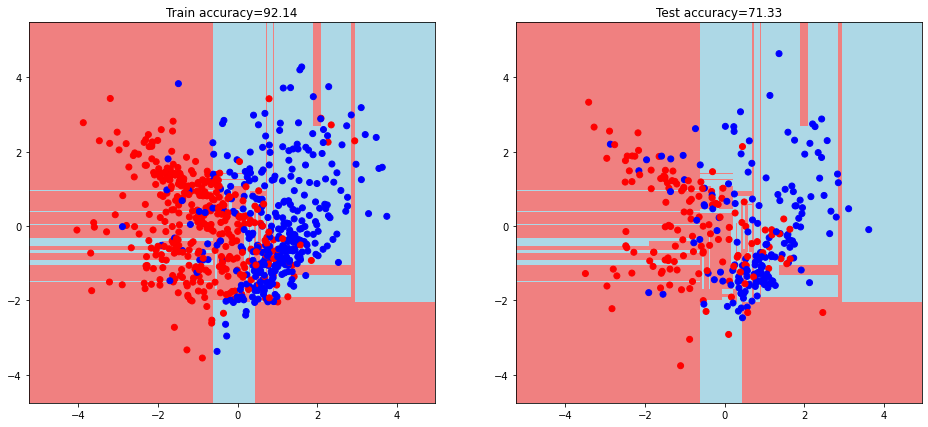

In [ ]:
visualize(train_data, test_data)

Построю лес из трех деревьев: 

In [ ]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

CPU times: user 1.4 s, sys: 5.33 ms, total: 1.4 s
Wall time: 1.44 s


In [ ]:
# получаю ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_3, train_data)

In [ ]:
# получаю ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_3, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 94.857
Точность случайного леса из 3 деревьев на тестовой выборке: 75.000


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_3, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

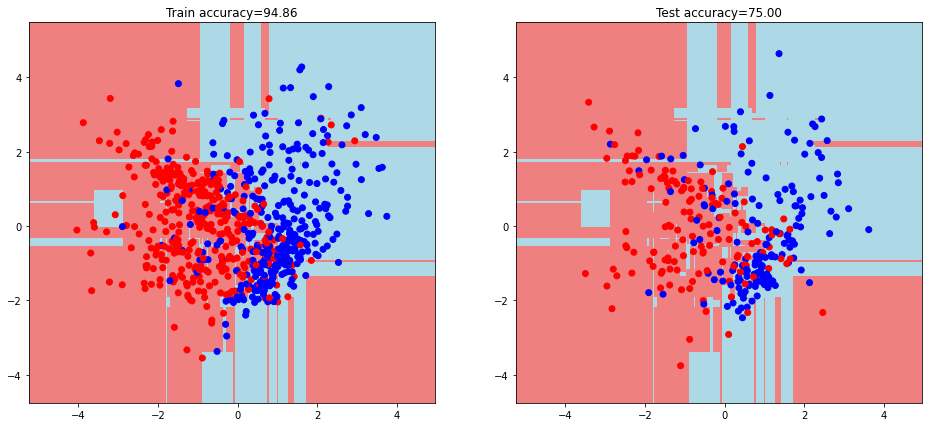

In [ ]:
visualize(train_data, test_data)

Построю лес из десяти деревьев: 

In [ ]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

CPU times: user 4.76 s, sys: 17.1 ms, total: 4.78 s
Wall time: 4.84 s


In [ ]:
# получаю ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_10, train_data)

In [ ]:
# получаю ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_10, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.143
Точность случайного леса из 10 деревьев на тестовой выборке: 77.333


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_10, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

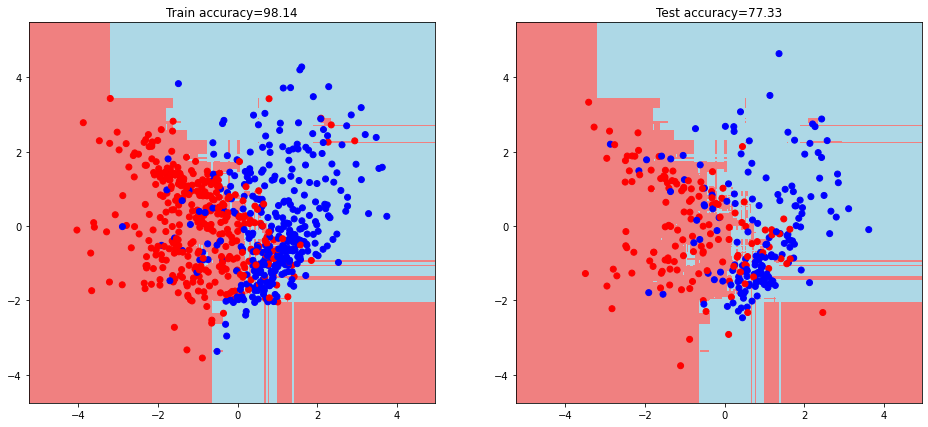

In [ ]:
visualize(train_data, test_data)

Построю лес из пятидесяти деревьев: 

In [ ]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

CPU times: user 17.5 s, sys: 60.3 ms, total: 17.6 s
Wall time: 17.7 s


In [ ]:
# получу ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_50, train_data)

In [ ]:
# получу ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_50, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 79.667


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_50, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

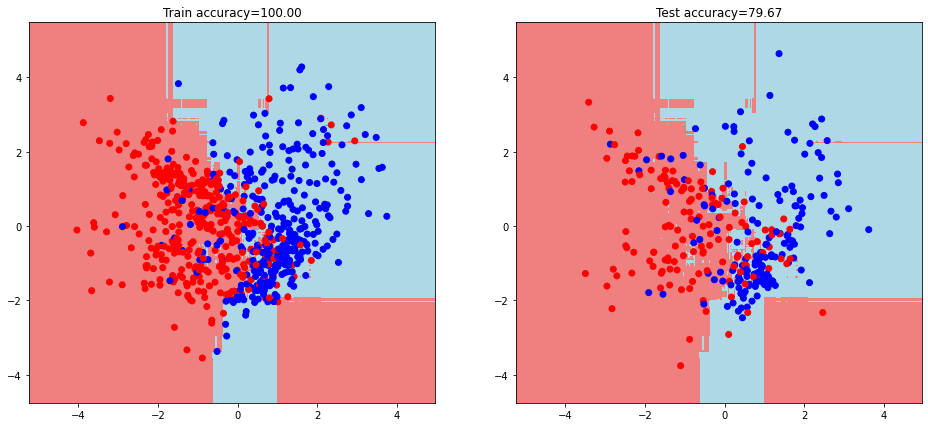

In [ ]:
visualize(train_data, test_data)

Построю лес из ста деревьев: 

In [ ]:
%%time
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

CPU times: user 36.1 s, sys: 136 ms, total: 36.3 s
Wall time: 36.5 s


In [ ]:
# получу ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_100, train_data)

In [ ]:
# получу ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_100, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 78.000


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_100, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

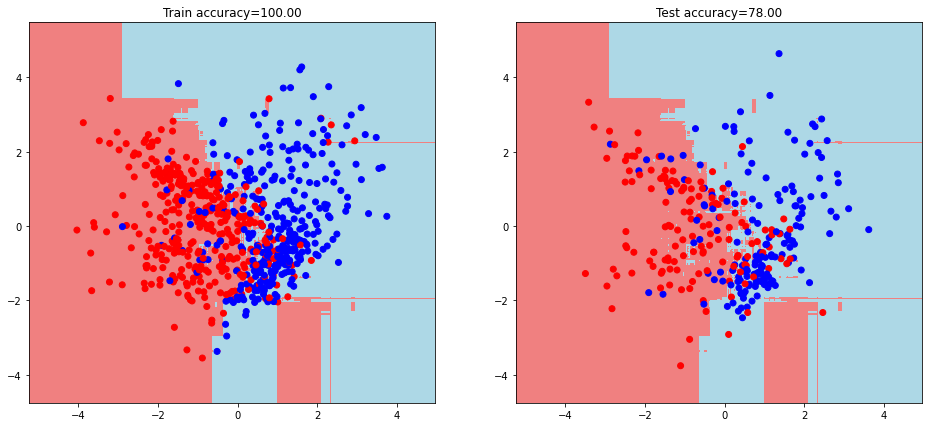

In [ ]:
visualize(train_data, test_data)

Построю лес из двухсот деревьев: 

In [ ]:
%%time
n_trees = 200
my_forest_200 = random_forest(train_data, train_labels, n_trees)

CPU times: user 1min 12s, sys: 252 ms, total: 1min 12s
Wall time: 1min 13s


In [ ]:
# получу ответы для обучающей выборки: 

train_answers = tree_vote(my_forest_200, train_data)

In [ ]:
# получу ответы для тестовой выборки: 

test_answers = tree_vote(my_forest_200, test_data)

In [ ]:
# точность на обучающей выборке: 

train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# точность на тестовой выборке: 

test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000
Точность случайного леса из 200 деревьев на тестовой выборке: 79.333


In [ ]:
# визуализирую лес на графике: 

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_200, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

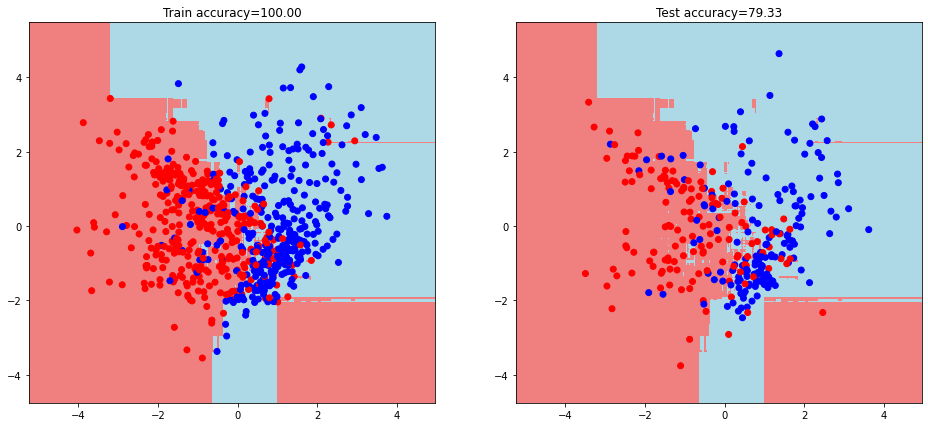

In [ ]:
visualize(train_data, test_data)

Выводы: 

В зависимости от количества деревьев в случайном лесе сложность гиперплоскости возрастает ощутимо. Модель всё более детально разбивает пространство на потенциальные предсказания классов. 

При количестве деревьев 1, 3, 10, как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает, но не достигает 100%, что свидетельствует о некотором недообучении. 

А вот при количестве деревьев 50, 100, 200 точность на обучающей выборке максимальна (100%), а на тестовой выборке колеблется на уровне 78-79%. 

Действительно, одна из основных и положительных особенностей случайного леса: он редко переобучается при увеличении числа базовых алгоритмов - слабо подвержен переобучению, а ошибка выходит на асимптоту.